<a href="https://colab.research.google.com/github/treasure-data/td-notebooks/blob/master/machine-learning/movielens/matrix_factorization.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
This notebook shows how to use Matrix Factorization of Hivemall with [movielens dataset](https://grouplens.org/datasets/movielens/).  
Matrix Factorization can be used for
1. Recommendation model.
2. a way of dimension reduction.  

As for the algorithm, please refer to [wikipedia](https://en.wikipedia.org/wiki/Matrix_factorization_(recommender_systems)  

This notebook focuses on Recommandation.

# SetUp

In [1]:
from getpass import getpass
td_api_key = getpass('Enter TD API KEY here ')
database   = input('Enter YOUR DATABASE to create tables here ')
assert database, "Error: Input YOUR DATABASE"
endpoint   = input('Enter YOUR ENDPOINT to create tables here (default: "api.treasuredata.com") \nref : https://support.treasuredata.com/hc/en-us/articles/360001474288-Sites-and-Endpoints ')
endpoint = endpoint if endpoint else 'https://api.treasuredata.com/'
endpoint = 'https://' + endpoint if not endpoint.startswith('https://') else endpoint
use_spark  = input('If enable to use spark, enter "true" (default: false) ').lower()
use_spark  = use_spark == 'true'
table = 'livedoor_news'

Enter TD API KEY here ··········
Enter YOUR DATABASE to create tables here hivemall
Enter YOUR ENDPOINT to create tables here (default: "api.treasuredata.com") 
ref : https://support.treasuredata.com/hc/en-us/articles/360001474288-Sites-and-Endpoints 
If enable to use spark, enter "true" (default: false) true


In [0]:
%%capture
!pip install td-client
!pip install pandas-td
!pip install -q git+https://github.com/takuti/pytd@master#egg=treasure-data[spark]

import numpy as np
import pandas as pd
import pandas_td as td
import matplotlib.pyplot as plt
import seaborn as sns
import pytd
import tdclient
pd.options.display.max_columns = 30

%matplotlib inline
con = td.connect(apikey=td_api_key, endpoint=endpoint)
c = tdclient.Client(apikey=td_api_key, endpoint=endpoint)
presto = td.create_engine('presto:{}'.format(database), con=con)
hive = td.create_engine('hive:{}'.format(database), con=con)

def recreate_table(client, table, database=database):
  if table in [table.name for table in client.tables(database)]:
    client.delete_table(database, table)
  client.create_log_table(database, table)
  return None

# Data Prepareation


In [0]:
%%capture
!wget -o ml-lm.zip http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip -o ml-1m.zip

In [0]:
import time
import pandas as pd
movies = pd.read_csv('./ml-1m/movies.dat', sep='\:\:', names=['movie_id', 'title', 'genres'], engine='python')
ratings  = pd.read_csv('./ml-1m/ratings.dat',  sep='\:\:', names=['user_id', 'movie_id', 'rating', 'time'], engine='python')
ratings['rowid'] = list(range(ratings.shape[0]))

In [0]:
# Upload
import time
if use_spark:
  client = pytd.Client(database=database, apikey=td_api_key)
  client.load_table_from_dataframe(movies, '{}.{}'.format(database, 'movielens_movies'), if_exists='overwrite')
  client.load_table_from_dataframe(ratings, '{}.{}'.format(database, 'movielens_ratings'), if_exists='overwrite')
else:
  for table in ['movielens_movies', 'movielens_ratings']:
    recreate_table(c, table)
  td.to_td(ratings, '{}.{}'.format(database, 'movielens_ratings'), con, if_exists='replace', time_col='time', index=False, chunksize=100000)
  td.to_td(movies, '{}.{}'.format(database, 'movielens_movies'), con, if_exists='replace', index=False)
  time.sleep(300)

# EDA

## movielens_movies

### Sample

In [6]:
td.read_td_query('''
select
  *
from 
  movielens_movies
limit 2
''', engine=presto)

,movie_id,title,genres,time
0,1,Toy Story (1995),Animation|Children's|Comedy,1550829875
1,2,Jumanji (1995),Adventure|Children's|Fantasy,1550829875


### Size

In [7]:
td.read_td_query('''
select
  count(*)
from
  movielens_movies
''', engine=presto)

,_col0
0,3883


### # of movies for each genres

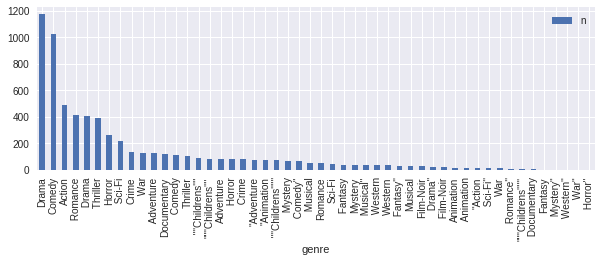

In [0]:
td.read_td_query('''
  select
    genre
    ,count(*) as n
  from
    movielens_movies
  CROSS JOIN 
    UNNEST(genres) AS t (genre)
  group by
    1''', engine=presto, index_col='genre').sort_values('n', ascending=False).plot.bar(figsize=(10,3))
plt.show()

## ratings

### sample

In [8]:
td.read_td_query('''
select
  *
from
  movielens_ratings
limit 5
''', engine=presto)

,user_id,movie_id,rating,rowid,time
0,1,1193,5,0,978300760
1,1,661,3,1,978302109
2,1,914,3,2,978301968
3,1,3408,4,3,978300275
4,1,2355,5,4,978824291


### size

In [9]:
td.read_td_query('''
select
  count(*)
from
  movielens_ratings
''', engine=presto)

,_col0
0,1000209


### # of movies for each rate

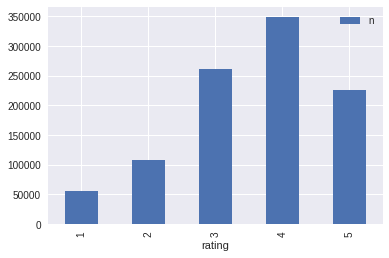

In [0]:
td.read_td_query('''
  select
    rating
    ,count(*) as n
  from
    movielens_ratings
  group by
    1''', engine=presto, index_col='rating').sort_index().plot.bar();plt.show()

### # of users and movies

In [10]:
td.read_td_query('''
select 
  count(distinct user_id) as users
  ,cast(count(*) as double) / count(distinct movie_id) as users_per_movie
  ,count(distinct movie_id) as movies
  ,cast(count(*) as double) / count(distinct user_id) as movies_per_user
from
  movielens_ratings
''', engine=presto)

,users,users_per_movie,movies,movies_per_user
0,6040,269.889099,3706,165.597517


### histgram of # of watched movies for each user

In [11]:
td.read_td_query('''
with users as (
  select
    user_id
    ,count(*) as n
  from
    movielens_ratings
  group by
    1
)

select
  avg(n) as mean, min(n) as min, approx_percentile(n, 0.25) as q1, approx_percentile(n, 0.5) as q2, approx_percentile(n, 0.75) as q3, max(n) as max
from
  users
''', engine=presto)

,mean,min,q1,q2,q3,max
0,165.597517,20,44,96,208,2314


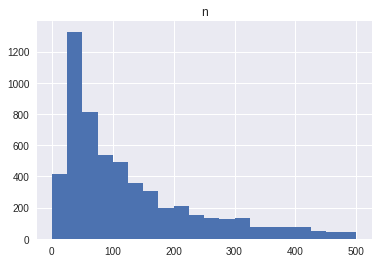

In [0]:
td.read_td_query('''
  select
    user_id
    ,count(*) as n
  from
    movielens_ratings
  group by
    1''', engine=presto, index_col='user_id').hist(bins=20, range=(0,500));

### histgram of # of watching users for each movie

In [12]:
td.read_td_query('''
with movies as (
  select
    movie_id
    ,count(*) as n
  from
    movielens_ratings
  group by
    1
)

select
  avg(n) as mean, min(n) as min, approx_percentile(n, 0.25) as q1, approx_percentile(n, 0.5) as q2, approx_percentile(n, 0.75) as q3, max(n) as max
from
  movies
''', engine=presto)

,mean,min,q1,q2,q3,max
0,269.889099,1,33,124,351,3428


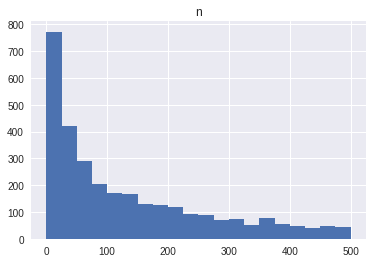

In [0]:
td.read_td_query('''
  select
    movie_id
    ,count(*) as n
  from
    movielens_ratings
  group by
    1''', engine=presto, index_col='movie_id').hist(bins=20, range=(0,500));

# Preprocessing

Split `movielens_ratings` into train and test

In [0]:
recreate_table(c, 'movielens_ratings_split_train_test')

In [14]:
td.read_td_query('''
insert into movielens_ratings_split_train_test 
with split as (
  select
    *
    ,case when rand() < 0.8 then 0 else 1 end as test_flg
  from
    movielens_ratings
)

select
  split.*
from 
  split
  inner join (
    select
      distinct movie_id
    from
      split
    where
       test_flg = 0
  ) movies_in_train
  on
    split.movie_id = movies_in_train.movie_id
''', engine=presto)

,rows
0,1000181


# Build a model

In [0]:
recreate_table(c, 'movielens_mf_model')

In [15]:
td.read_td_query('''
select
  avg(rating)
from
  movielens_ratings_split_train_test
where
  test_flg = 0
''', engine=presto)

,_col0
0,3.581573


In [16]:
td.read_td_query('''
insert overwrite table movielens_mf_model
select
  idx, 
  array_avg(u_rank) as Pu, 
  array_avg(m_rank) as Qi, 
  avg(u_bias) as Bu, 
  avg(m_bias) as Bi
from (
  select 
    train_mf_sgd(user_id, movie_id, rating, '-factor 10 -mu 3.582 -iter 50') as (idx, u_rank, m_rank, u_bias, m_bias)
  from 
    movielens_ratings_split_train_test
  where
    test_flg = 0
) t
group by idx
''', engine=hive)

,idx,pu,qi,bu,bi


Check the created table.

In [17]:
td.read_td_query('''
select
  *
from
  movielens_mf_model
limit 5
''', engine=hive)

,idx,pu,qi,bu,bi,v,time
0,0,None,None,0.000000,0.000000,"{'time': '1550830004', 'idx': '0', 'bi': '0.0'...",1550830004
1,1,"[-0.35504552721977234, 0.6105542778968811, 0.6...","[0.20341399312019348, 0.3009406328201294, -0.0...",0.003905,0.554420,"{'time': '1550830004', 'idx': '1', 'bi': '0.55...",1550830004
2,2,"[-0.016563519835472107, -0.34515732526779175, ...","[-0.2695683538913727, 0.02534143626689911, -0....",-0.033781,-0.275475,"{'time': '1550830004', 'idx': '2', 'bi': '-0.2...",1550830004
3,3,"[-0.579686164855957, -0.2448955774307251, -0.5...","[-0.12964022159576416, -0.04885559901595116, 0...",-0.003477,-0.497057,"{'time': '1550830004', 'idx': '3', 'bi': '-0.4...",1550830004
4,4,"[0.3183121383190155, 0.8762376308441162, -0.50...","[-0.11252906918525696, 0.016183411702513695, -...",-0.000968,-0.568835,"{'time': '1550830004', 'idx': '4', 'bi': '-0.5...",1550830004


In [18]:
td.read_td_query('''
select
  count(pu) as n_pu -- the number of users
  ,count(qi) as n_qi -- the number of movies
from
  movielens_mf_model
''', engine=presto)

,n_pu,n_qi
0,6040,3655


In [19]:
td.read_td_query('''
select
  cardinality(pu) as length_pu
  ,cardinality(qi) as length_qi
from
  movielens_mf_model
where
  idx = 1
''', engine=presto)

,length_pu,length_qi
0,10,10


The table, `movielens_mf_model`, represents factors of user_id and movie_id.  
Concretely, `pu`, `qi`, `bu`, `bi` of idx = 1 represents the factor of user_id = 1, the factor of movie_id = 1, the bias of user_id = 1 and the bias of movie_id = 1 respectively.  
Also, confirm that length of `pu` and `qi` are same with `factor`

# Prediction

In [0]:
recreate_table(c, 'movielens_mf_predict')

In [20]:
td.read_td_query('''
insert into table movielens_mf_predict
select
  test_flg
  ,t.user_id
  ,t.movie_id
  ,rating
  ,mf_predict(user_factor.pu, movie_factor.qi, user_factor.bu, movie_factor.bi, 3.582) as predicted
from
  movielens_ratings_split_train_test t 
  LEFT OUTER JOIN movielens_mf_model user_factor
    ON t.user_id = user_factor.idx
  LEFT OUTER JOIN movielens_mf_model movie_factor
    ON t.movie_id = movie_factor.idx
''', engine=hive)

,test_flg,user_id,movie_id,rating,predicted


Chech the created table

In [21]:
td.read_td_query('''
select
  *
from
  movielens_mf_predict
limit 3
''', engine=presto)

,test_flg,user_id,movie_id,rating,predicted,time
0,0,964,3952,5,3.958522,1550830088
1,0,1010,3952,5,3.331382,1550830088
2,0,1009,3952,2,4.156105,1550830088


# Evaluation

In [22]:
td.read_td_query('''
select
  test_flg
  ,sqrt(avg(power(rating - predicted, 2))) as rmse_model
  ,sqrt(avg(power(rating - 4.0, 2))) as rmse_random_model
from
  movielens_mf_predict
group by
  1
''', engine=presto)

,test_flg,rmse_model,rmse_random_model
0,1,0.902008,1.193794
1,0,0.853919,1.192653


The most frequest value of `rating` is 4.0, so 4.0 is specified as a value of random model.  
Matrix Factorization model is better than the random model.

# Recommendation

In [0]:
recreate_table(c, 'movielens_mf_recommendation')

In [23]:
td.read_td_query('''
with recommend as (
  select
    user_factor.idx as user_id
    ,movie_factor.idx as movie_id
    ,mf_predict(user_factor.pu, movie_factor.qi, user_factor.bu, movie_factor.bi, 3.582) as predicted
  from
    movielens_mf_model user_factor
    CROSS JOIN 
    movielens_mf_model movie_factor
  where
    user_factor.pu is not null
    and
    movie_factor.qi is not null
)

insert into table movielens_mf_recommendation
select
  recommend.*
from
  recommend
  left outer join
  movielens_ratings_split_train_test t
  on
    recommend.user_id = t.user_id
    and
    recommend.movie_id = t.movie_id
where
  t.rating is null
''', engine=hive)

,user_id,movie_id,predicted


Based on the predicted scores, you can choose recommendations.

In [26]:
td.read_td_query('''
select
  *
from
  movielens_mf_recommendation
where
  user_id = 4024
order by
  predicted desc
limit 5
''', engine=presto)

,user_id,movie_id,predicted,time
0,4024,260,5.283364,1549614193
1,4024,1198,5.182836,1549614193
2,4024,296,5.091716,1549614193
3,4024,858,5.021028,1549614193
4,4024,922,4.972469,1550830193
